# Описание набора данных

Данные описывают выборку звезд в пульсары (редкий тип нейтронных звезд), собранных в ходе исследования Вселенной, доктором Робертом Лайон из Манчестерского университета (Великобритания).

Признак  | Описание
-------------------|--------------------
MIP | Среднее значение интегрированного профиля
STDIP | Стандартное отклонение интегрированного профиля
EKIP | Избыточный эксцесс интегрированного профиля
SIP | Асимметрия интегрированного профиля
MC | Среднее значение кривой DM-SNR
STDC | Стандартное отклонение кривой DM-SNR
EKC | Избыточный эксцесс кривой DM-SNR
SC | Асимметрия кривой DM-SNR
TG | Класс

# Подключение необходимых библиотек и импорт данных

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

In [113]:
data = pd.read_csv('https://studio.openedu.ru/asset-v1:ITMOUniversity+DATANFST2035+cifru_2035+type@asset+block@pulsar_stars_new.csv', 
                       delimiter=',', 
                       decimal='.')

In [114]:
data

,MIP,STDIP,EKIP,SIP,MC,STDC,EKC,SC,TG
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


# Визуализация данных

Посмотрим на описательные характеристики датасета и убедимся, что пропуски в данных отсутствуют.

In [115]:
data.describe()

,MIP,STDIP,EKIP,SIP,MC,STDC,EKC,SC,TG
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


In [116]:
data.isna().sum()

MIP      0
STDIP    0
EKIP     0
SIP      0
MC       0
STDC     0
EKC      0
SC       0
TG       0
dtype: int64

Посмотрим на соотношение классов отклика (TG).

Классы дисбалансированы (можно применить какие-нибудь методы для их балансировки).

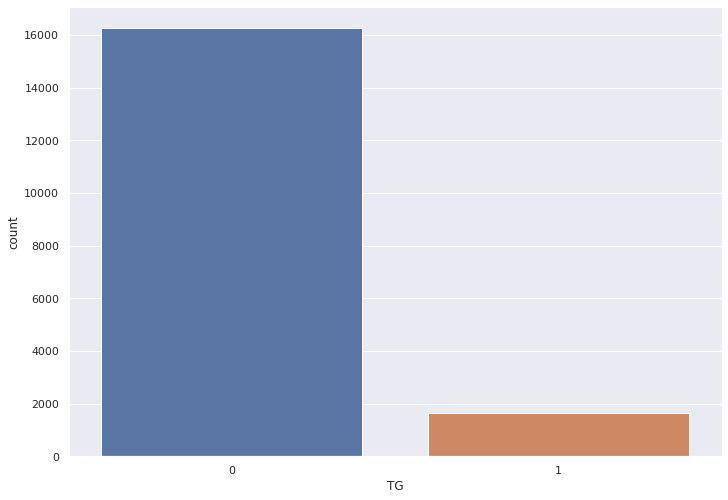

In [117]:
sns.countplot(x='TG', data=data)

Построим корреляционную матрицу, чтобы посмотреть на взаимосвязь признаков и их влияние на целевую переменную.

**MIP**, **EKIP**, **SIP** являются наиболее сильными предикторами класса.

**EKIP**, **SIP** имеют сильную корреляцию 0.95, поэтому позже удалим одну из коррелированных переменных.

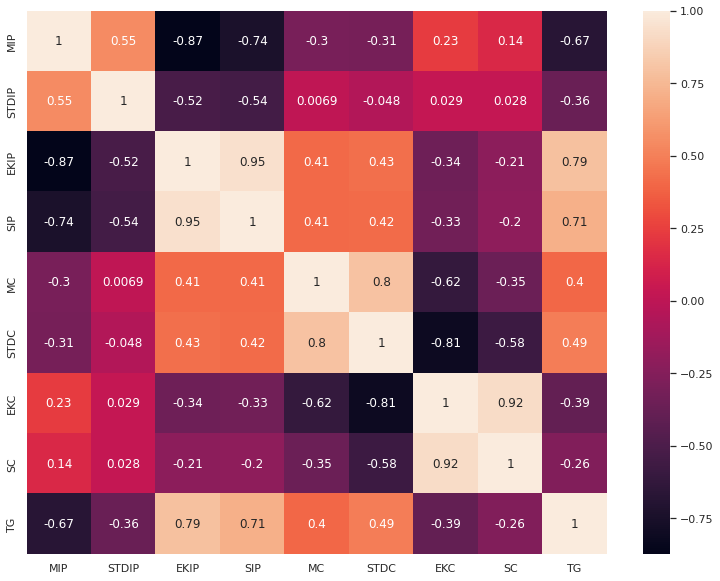

In [118]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), annot=True)

Посмотрим на наличие выбросов.

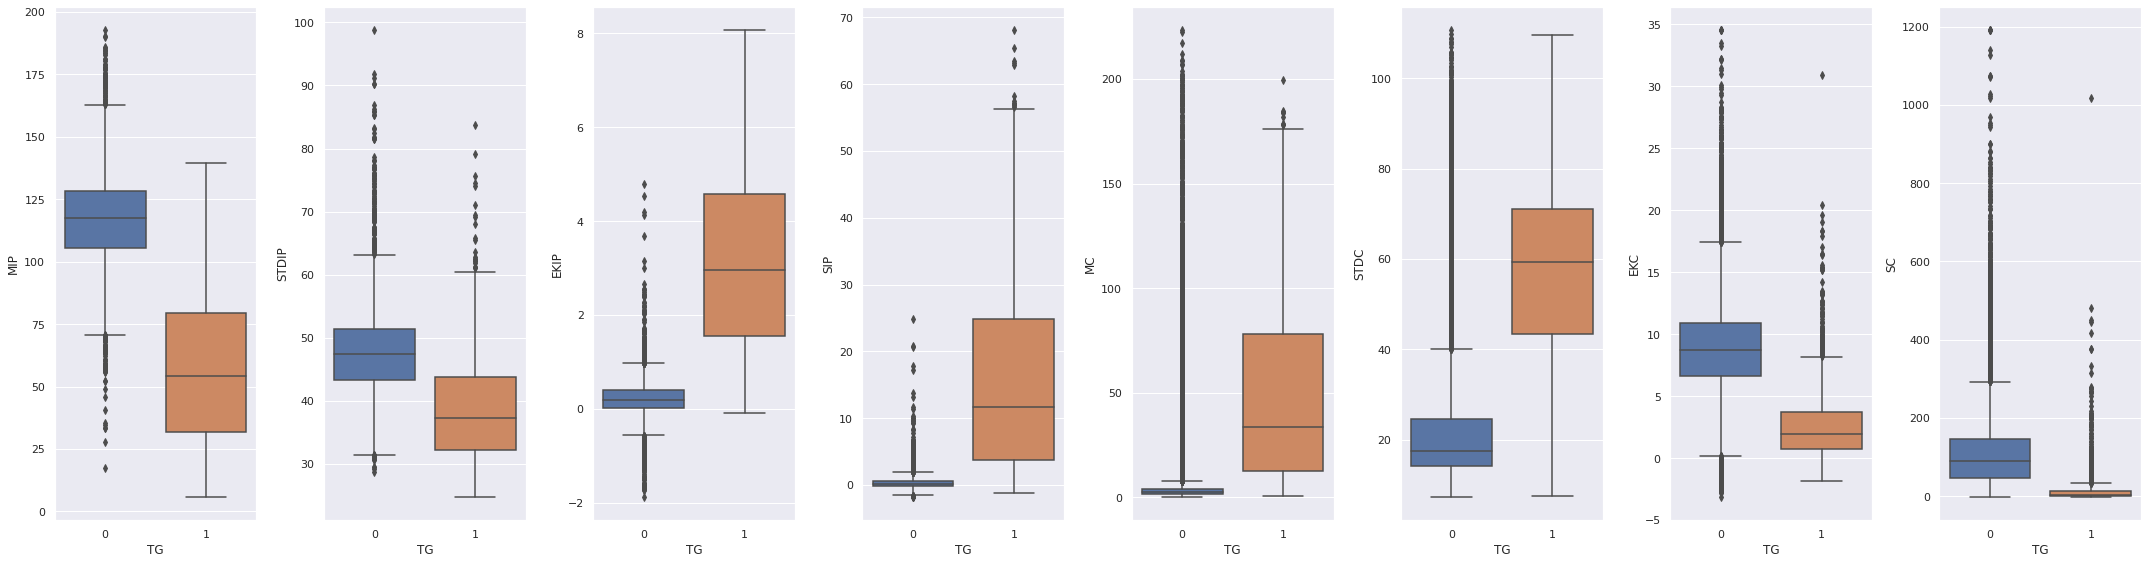

In [119]:
fig, axes = plt.subplots(ncols=8, figsize=(30,8))

for i, col in enumerate(data.columns.drop('TG')):
    sns.boxplot(x='TG', y=col, data=data, ax=axes[i])
    
plt.tight_layout()

Видим выбросы, но не будем их удалять, т.к. не обладаем достаточными знаниями о предметной области.

# Предобработка данных

Произведем стандартизацию, чтобы предикторы не отличались порядком друг от друга.

Удалим одну из коррелирующих предикторов.

Разделим датасет на две части: для обучения и предсказания.

In [120]:
data

,MIP,STDIP,EKIP,SIP,MC,STDC,EKC,SC,TG
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [121]:
train = data.head(int(len(data)*0.8))
test = data.tail(int(len(data)*0.2))

In [122]:
scaler = StandardScaler()

X_train = pd.DataFrame(train.drop(['TG','SIP'], axis=1))
X_train = pd.DataFrame(data = scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)
y_train = pd.DataFrame(train['TG'])

Аналогичные действия сразу проделаем для тестового набора.

In [123]:
X_test = pd.DataFrame(test.drop(['TG','SIP'], axis=1))
X_test = pd.DataFrame(data = scaler.fit_transform(X_test), index = X_test.index, columns = X_test.columns)
y_test = pd.DataFrame(test['TG'])

# Построение моделей

Задача - произвести классификацию звезд по их характеристикам.

Попробуем это сделать следующими моделями:

**1) Logistic Regression**

In [124]:
reg = LogisticRegression(random_state=2019, solver='lbfgs').fit(X_train, y_train.values.ravel())

In [125]:
y_pred = reg.predict(X_test)

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3526
           1       0.16      0.92      0.27        53

    accuracy                           0.93      3579
   macro avg       0.58      0.93      0.62      3579
weighted avg       0.99      0.93      0.95      3579



**2) KNN**

In [127]:
neigh = KNeighborsClassifier().fit(X_train, y_train.values.ravel())

In [128]:
y_pred = neigh.predict(X_test)

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3526
           1       0.13      0.77      0.22        53

    accuracy                           0.92      3579
   macro avg       0.56      0.85      0.59      3579
weighted avg       0.98      0.92      0.95      3579



**3) SVM**


In [130]:
svm = LinearSVC(random_state = 2019, max_iter=4000).fit(X_train, y_train.values.ravel())

In [131]:
y_pred = svm.predict(X_test)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3526
           1       0.19      0.92      0.31        53

    accuracy                           0.94      3579
   macro avg       0.59      0.93      0.64      3579
weighted avg       0.99      0.94      0.96      3579



**4) Decision Tree**

In [133]:
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=10,
                              max_leaf_nodes=15,
                              random_state=2019).fit(X_train, y_train)

In [134]:
y_pred = tree.predict(X_test)

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3526
           1       0.10      0.89      0.17        53

    accuracy                           0.87      3579
   macro avg       0.55      0.88      0.55      3579
weighted avg       0.98      0.87      0.92      3579



**5) Random Forest**


In [136]:
forest = RandomForestClassifier(n_estimators=19, 
                             criterion='entropy', 
                              min_samples_leaf=10, 
                              max_leaf_nodes=20, 
                              random_state=2019).fit(X_train, y_train.values.ravel())

In [137]:
y_pred = forest.predict(X_test)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3526
           1       0.10      0.87      0.19        53

    accuracy                           0.89      3579
   macro avg       0.55      0.88      0.56      3579
weighted avg       0.98      0.89      0.93      3579



# Оценка моделей

Если сравнивать модели по **Accuracy**, то лучшие модели **SVM**, **LogisticRegression**, **KNN** в порядке убывания метрики.

Алгоритмы на основе деревьем оказались неудачными.